# Machine Learning FAIMS
## A very rough draft

### Normalized aa counts, Length, Charge, Sequence and Weights

In [14]:
#Defining function for my colorplot

import matplotlib.pyplot as plt
def mycolorplot(actual, model, cfeature = 'Charge'):
    plt.scatter(actual, model, c = X2[cfeature], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow', 7))
    
    plt.colorbar(label='Charge', ticks=range(7))
    
    
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')


In [13]:
#Defining the function for adding the pyteomic pieces
from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem


def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)



In [1]:
import pandas as pd
import sklearn
import sklearn.ensemble

In [2]:
evidence_df = pd.read_csv("Features_AvgMaxCV_Weights.csv", low_memory=False)
evidence_df.head()

,Sequence,Charge,Intensity,Length,Modifications,Modified.sequence,Oxidation..M..Probabilities,Oxidation..M..Score.Diffs,Acetyl..Protein.N.term.,Oxidation..M.,...,L.Norm,K.Norm,M.Norm,F.Norm,S.Norm,T.Norm,W.Norm,Y.Norm,V.Norm,P.Norm
0,AAAAAAAAAAAAAAAGAGAGAK,2,548850.0,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,...,0.000000,0.045455,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,AAAAAAAAAAAAAAAGAGAGAK,3,7280200.0,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,...,0.000000,0.045455,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,4,12120000.0,52,Unmodified,_AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVG...,NaN,NaN,0,0,...,0.019231,0.000000,0.0,0.0,0.057692,0.057692,0.0,0.0,0.057692,0.076923
3,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,5,14383000.0,52,Unmodified,_AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVG...,NaN,NaN,0,0,...,0.019231,0.000000,0.0,0.0,0.057692,0.057692,0.0,0.0,0.057692,0.076923
4,AAAAAAAAAVSR,2,14281000.0,12,Unmodified,_AAAAAAAAAVSR_,NaN,NaN,0,0,...,0.000000,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.083333,0.000000


In [3]:
type(evidence_df)

pandas.core.frame.DataFrame

In [4]:
#Lets add a PEP filter

badscores = evidence_df[evidence_df['PEP'] > 0.01].index     #makes vector of indices of all PEPs above 
                                                             #Couldn't do it on bad scores because it is NOT two-dimenstional
evidence_df.drop(badscores, inplace=True)       #Delete these bad scoring indices from the array
evidence_df.index = range(len(evidence_df))    #Need to reset the indices of your table so they match much like rownames in R

#And then also remove psm with few observations
badscores = evidence_df[evidence_df['Weighting'] < 1].index     #makes vector of indices of all PEPs above 
                                                             #Couldn't do it on bad scores because it is NOT two-dimenstional
evidence_df.drop(badscores, inplace=True)       #Delete these bad scoring indices from the array
evidence_df.index = range(len(evidence_df))    #Need to reset the indices of your table so they match much like rownames in R


evidence_df.shape
#evidence_df.index


(103152, 106)

In [5]:
#WANT TO TRY ONE-HOT WITH LIST THAT I THEN CONVERT INTO FRAME AFTERWARD
#WOULD ALSO ALLOW FOR THE USE OF THE KARAS PADDING FUNCTION SO THAT I CAN HIT THEM ALL WITH ZEROS AT THE SAME TIME
import numpy as np
from numpy import array
from numpy import argmax                   #finds the index of the maximum value in a vector
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences

#Start by finding the max and calculating needed vector length
VEC_LENGTH = max(evidence_df['Length']) * 20

#Define what residues are possible
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY ' 

#TURNING CHARACTERS INTO INTEGERS
# Map character keys to integer values in a dictionary, then map integer keys to character values to revers transform
char_to_int = dict((c, i) for i, c in enumerate(AMINO_ACIDS))   #character keys to integer values
int_to_char = dict((i, c) for i, c in enumerate(AMINO_ACIDS))   #integer keys to character values


hotlist = list()
#Build out the rest of the sequences' one-hot arrays

for i in range(0, evidence_df.shape[0]):
    
    pep = evidence_df['Sequence'][i]
    integer_encode = [char_to_int[char] for char in pep]
    encoded = to_categorical(integer_encode, num_classes=20)
    flatencode = encoded.flatten()
    
    #numzeros = VEC_LENGTH - len(flatencode)
    #flatencode = np.append(flatencode, [[0] * numzeros])
    
    hotlist.append(flatencode)

padded = pad_sequences(hotlist, padding= 'post', maxlen=VEC_LENGTH)

hotarray = np.array(padded)

hotarray.shape


Using TensorFlow backend.


(103152, 1100)

In [16]:
evidence_df = addfeatures(evidence_df)
evidence_df.columns

Index(['Sequence', 'Charge', 'Intensity', 'Length', 'Modifications',
       'Modified.sequence', 'Oxidation..M..Probabilities',
       'Oxidation..M..Score.Diffs', 'Acetyl..Protein.N.term.', 'Oxidation..M.',
       ...
       'F.Norm', 'S.Norm', 'T.Norm', 'W.Norm', 'Y.Norm', 'V.Norm', 'P.Norm',
       'pyMass', 'pI', 'pyCharge'],
      dtype='object', length=109)

In [115]:
feature_subset1 = ['Charge','Length','A.Norm', 'R.Norm',
       'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm',
       'I.Norm', 'L.Norm', 'K.Norm', 'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm',
       'W.Norm', 'Y.Norm', 'V.Norm', 'P.Norm', 'pI', 'Mass', 'pyCharge']
target_value = ['AvgMaxCV']

In [118]:
X = np.concatenate((evidence_df[feature_subset1], hotarray), axis = 1)
X.shape

(103152, 1125)

In [119]:
from sklearn.model_selection import train_test_split

#X = evidence_df[feature_subset1]
y = evidence_df[target_value]

#split the data with 80% in training set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.80)

y1 = y1.values.ravel() #Flatten the vector so that it is formatted correctly
y2 = y2.values.ravel()

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Random Forest Regressor

In [120]:
#Here fitting the training data to the model
from sklearn.ensemble import RandomForestRegressor   # 1. Choose a model class
forest = RandomForestRegressor(200)                  # 2. instantiate that model with select hyperparmeters


forest.fit(X1, y1)                                   # 3. fit the model to your test data

y2_model = forest.predict(X2)                        # 4. Apply the model to predicting target values for new data

In [121]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y2, y2_model))            #calculating the mean error in terms of deviation 


9.834038495302442

In [161]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest, X2, y2, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.69 (+/- 0.03)


#### Plot with all Length, Charge, Norm Counts, All pyteomic comps and pca one-hot(400, 95%) 

Text(0, 0.5, 'Predicted')

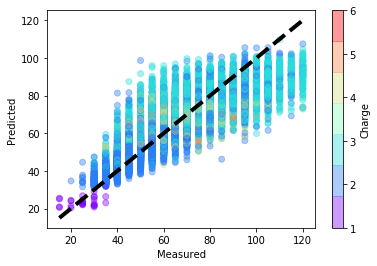

In [170]:
    plt.scatter(y2, y2_model, c = X2[:,0], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow', 7))
    
    plt.colorbar(label='Charge', ticks=range(7))
    
    
    plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

#### Plot using all Length, Charge, NormCounts, all pyteomic pieces and One-hot

Text(0, 0.5, 'Predicted')

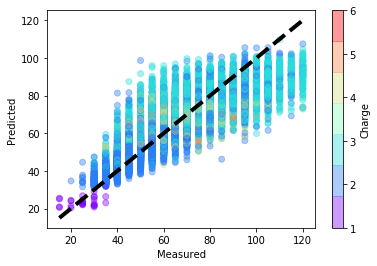

In [125]:
    plt.scatter(y2, y2_model, c = X2[:,0], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow', 7))
    
    plt.colorbar(label='Charge', ticks=range(7))
    
    
    plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

#### Plot using Length, Charge, NormCounts, pI, Mass, pyCharge

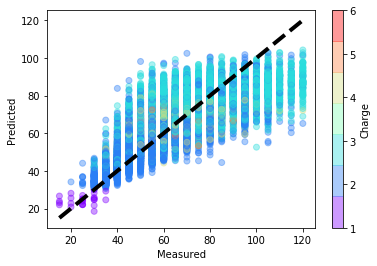

In [91]:
mycolorplot(y2, y2_model)

#### Plot using length, Charge, NormCounts, just Mass

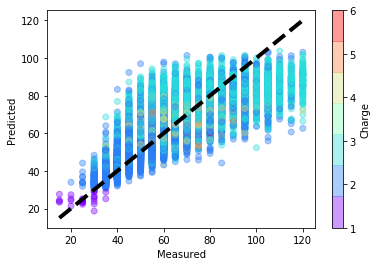

In [85]:
mycolorplot(y2, y2_model)

#### Plot using length, Charge, NormCounts, pI, Mass

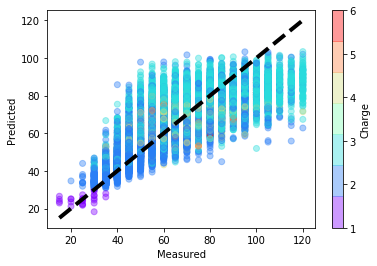

In [79]:
mycolorplot(y2, y2_model)

#### Plot using Length Charge Norm Counts pI

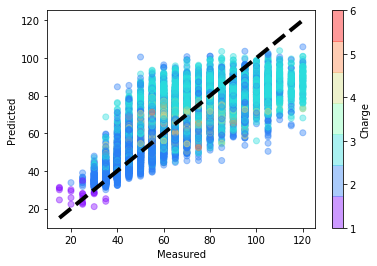

In [43]:
mycolorplot(y2, y2_model)

#### Plot using Length, Charge and Norm Counts

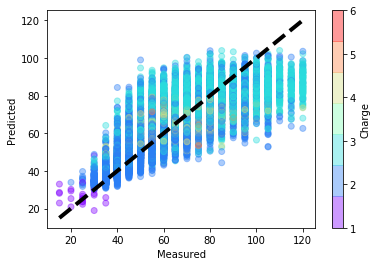

In [30]:
mycolorplot(y2, y2_model)

Not exactly stellar

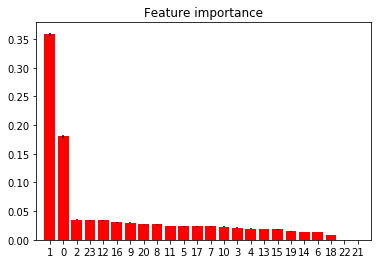

In [87]:
#Make array of feature importance
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Plot the feature importances of our model
plt.figure()
plt.title("Feature importance")
plt.bar(range(X1.shape[1]), importances[indices], color='r', yerr=std[indices], align = "center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()

In [17]:
type(y2)
model_error = np.absolute(y2_model - y2)
model_error.shape

combined_df = pd.DataFrame(fullX2)
combined_df["y2"] = y2
combined_df["y2_model"] = y2_model
combined_df["model_error"] = model_error
combined_df.columns


Index(['Sequence', 'Charge', 'Intensity', 'Length.x', 'A.Count', 'R.Count',
       'N.Count', 'D.Count', 'C.Count', 'Q.Count', 'E.Count', 'G.Count',
       'H.Count', 'I.Count', 'L.Count', 'K.Count', 'M.Count', 'F.Count',
       'P.Count', 'S.Count', 'T.Count', 'W.Count', 'Y.Count', 'V.Count',
       'U.Count', 'O.Count', 'A.Norm', 'R.Norm', 'N.Norm', 'D.Norm', 'C.Norm',
       'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'L.Norm', 'K.Norm',
       'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm', 'W.Norm', 'Y.Norm', 'V.Norm',
       'U.Norm', 'O.Norm', 'P.Norm', 'y2', 'y2_model', 'model_error'],
      dtype='object')

## Random Forest Classifier

#### Pretty bad so I think we can pass

In [221]:
feature_subset1 = ['Charge','Length','A.Norm', 'R.Norm',
       'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm',
       'I.Norm', 'L.Norm', 'K.Norm', 'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm',
       'W.Norm', 'Y.Norm', 'V.Norm', 'P.Norm', 'pI', 'Mass', 'pyCharge', 'Retention.time']
target_value = ['AvgMaxCV']

In [118]:
X = np.concatenate((evidence_df[feature_subset1], hotarray), axis = 1)
X.shape

(103152, 1125)

In [222]:
from sklearn.model_selection import train_test_split

X = evidence_df[feature_subset1]
y = evidence_df[target_value]

#split the data with 80% in training set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.80)

y1 = y1.values.ravel() #Flatten the vector so that it is formatted correctly
y2 = y2.values.ravel()

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [177]:
from sklearn.ensemble import RandomForestClassifier

forestC = RandomForestClassifier(n_estimators = 200, random_state = 0)

forestC.fit(X1,y1)

y2_fcmodel = forestC.predict(X2)

In [89]:
print(np.linspace(15,120, 22))
min(y2)

[ 15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.  80.
  85.  90.  95. 100. 105. 110. 115. 120.]


20

[[  1   0   0   0   1   0   0   2   0   1   0   0   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   3   2   0   1   7   0   1   2   1   0   0   0   0   0   0
    0   0   0]
 [  0   0   1  46  34  11   8   9   7   6   9   3   4   1   0   0   0   0
    0   0   0]
 [  0   0   1 122 249  40  31  19  43  34  25  15  25  10   3   2   2   0
    0   0   0]
 [  0   0   5  42 870 275 125  98  76  49  75  42  58  23  16  19  12   6
    2   5   3]
 [  1   1   8  13 328 449 313 175 112  85  91  69  68  38  38  22  21  15
    3   5   3]
 [  1   1  13  32 101 264 528 335 232 109 112  78  91  40  44  30  25   9
    5   4   3]
 [  3   2   9  43  81 109 421 480 363 142 158  78 101  28  28  22  18   5
    4   0   1]
 [  1   4  19  63 112  99 221 426 488 196 191  71 128  27  15  18  10   7
    4   0   1]
 [  1   2  16  40 118  92 131 277 375 221 246  70 144  11  14  18   7   5
    1   2   1]
 [  1   1   9  59 132 117 122 215 333 226 300  86 185  12  13  36   7   4
    2   1   1]
 [  2   1   4  31 115

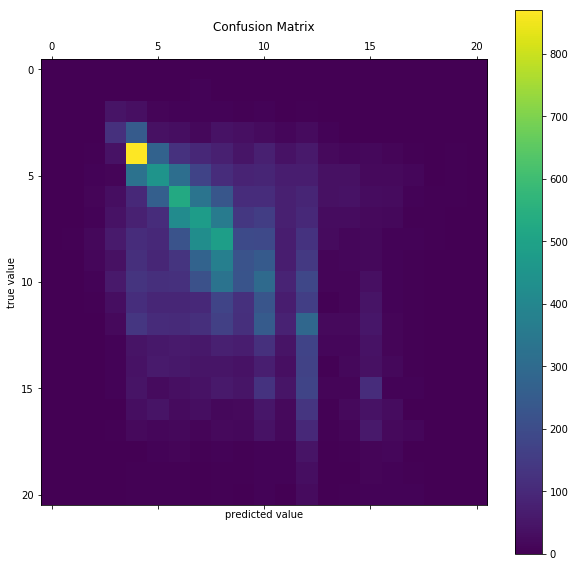

In [174]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
labels = np.linspace(20,120, 21)
mat = confusion_matrix(y2, y2_fcmodel, labels)

print(mat)

plt.rcParams['figure.figsize'] = [10,10]
fig = plt.figure()          
ax = fig.add_subplot(111) #adding a subplot that is a single frame/facet 111 = (1,1,1) describing rows columns and index, respectively
cax = ax.matshow(mat)          #displays and array as a matrix
plt.title('Confusion Matrix')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)            #have yet to figure how to label the axes correctly
#ax.set_yticklabels([''] + labels)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()


In [178]:
#Random forest classifier accuracy

from sklearn.model_selection import cross_val_score
scores = cross_val_score(forestC, X1, y1, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.23 (+/- 0.00)


## Support Vector Machine Regressor

In [373]:
feature_subset1 = ['Charge','Length','A.Norm', 'R.Norm',
       'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm',
       'I.Norm', 'L.Norm', 'K.Norm', 'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm',
       'W.Norm', 'Y.Norm', 'V.Norm', 'P.Norm', 'pI', 'pyCharge']
target_value = ['AvgMaxCV']

In [374]:
X = np.concatenate((evidence_df[feature_subset1], hotarray), axis = 1)
X.shape

(103152, 1124)

In [375]:
from sklearn.model_selection import train_test_split

#X = evidence_df[feature_subset1]
y = evidence_df[target_value]

#split the data with 80% in training set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.80)

y1 = y1.values.ravel() #Flatten the vector so that it is formatted correctly
y2 = y2.values.ravel()

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [376]:
from sklearn import svm
clf = svm.SVR(kernel = 'rbf', C= 10, gamma= 'scale')
clf.fit(X1,y1)
y2_svmodel = clf.predict(X2)

In [377]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y2, y2_svmodel))            #calculating the mean error in terms of deviation 


13.993655123018351

In [371]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X2, y2, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.48 (+/- 0.04)


In [372]:
hotarray.shape

(103152, 1100)

#### Plot for row 1 in OneNote (kernel = 'rbf',  no other parameters set)

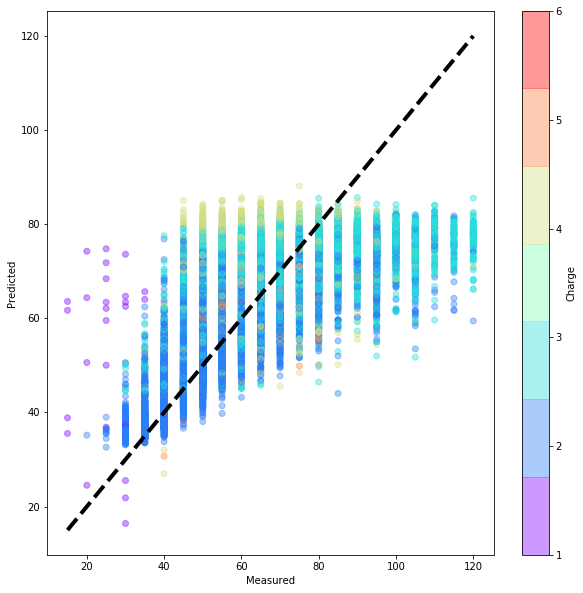

In [184]:
mycolorplot(y2, y2_svmodel)

#### Minor parameter optimization (kernel = 'rbf', C = 1000, gamma = scale)

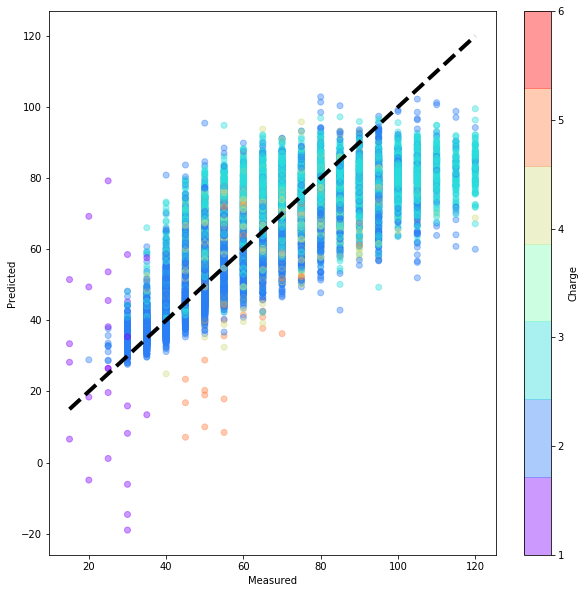

In [201]:
mycolorplot(y2, y2_svmodel)

In [369]:
#These plots are way too big
plt.rcParams['figure.figsize'] = [5,5]

#### Plot of SVR with Length, Charge, NormCounts and pI

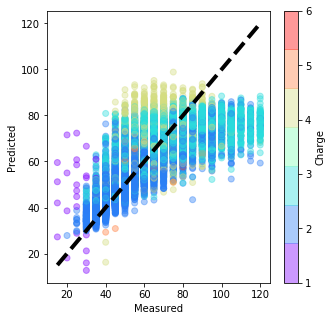

In [303]:
mycolorplot(y2, y2_svmodel)

#### Plot of SVR with Length, Charge, NormCounts, pI and pyMass, pyMass appears to make much worse

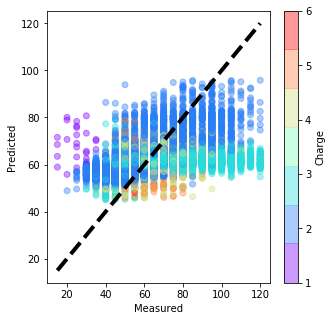

In [327]:
mycolorplot(y2, y2_svmodel)

#### Plot of SVR using Length Charge, NormCounts, pI, pyCharge and OneHot

Text(0, 0.5, 'Predicted')

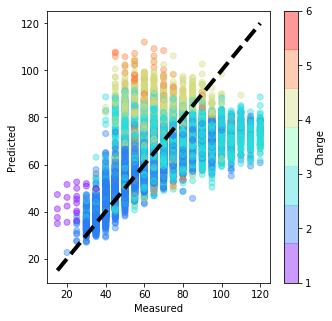

In [380]:
    plt.scatter(y2, y2_svmodel, c = X2[:,0], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow', 7))
    
    plt.colorbar(label='Charge', ticks=range(7))
    
    
    plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

## Support Vector Classifier

In [54]:
feature_subset1 = ['Charge','Length', 'A.Norm', 'R.Norm',
       'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm',
       'I.Norm', 'L.Norm', 'K.Norm', 'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm',
       'W.Norm', 'Y.Norm', 'V.Norm', 'P.Norm']
target_value = ['AvgMaxCV']

In [55]:
X = np.concatenate((evidence_df[feature_subset1], hotarray), axis = 1)
X.shape

(103152, 1122)

In [56]:
from sklearn.model_selection import train_test_split

#X = evidence_df[feature_subset1]
y = evidence_df[target_value]

#split the data with 80% in training set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.80)

y1 = y1.values.ravel() #Flatten the vector so that it is formatted correctly
y2 = y2.values.ravel()

In [57]:
from sklearn.svm import SVC
clfC = SVC(gamma= 'auto')
clfC.fit(X1, y1)
y2_svmodel = clfC.predict(X2)

In [58]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y2, y2_svmodel))            #calculating the mean error in terms of deviation 


16.85491813186681

In [59]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clfC, X2, y2, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.17 (+/- 0.01)


#### Just Charge and Length

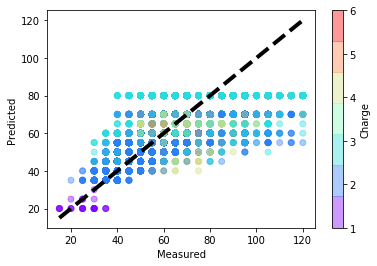

In [15]:
mycolorplot(y2, y2_svmodel)

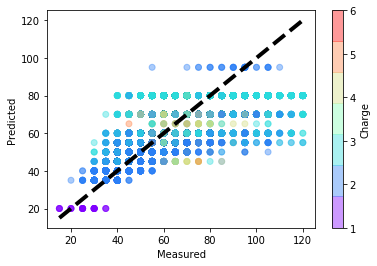

In [38]:
mycolorplot(y2, y2_svmodel)

[[  0   0   0   0   1   0   0   1   0   0   2   0   0   0   0   1   0   0
    0   0   0]
 [  0   0   0   4   3   0   0   1   2   1   4   0   2   0   0   0   0   0
    0   0   0]
 [  0   0   1  54  48   5   8   6   6   4   5   0   1   0   0   1   0   0
    0   0   0]
 [  0   0   0 201 249  80  38  24  15   6   7   1   0   0   0   0   0   0
    0   0   0]
 [  0   0   0  86 803 398 240 149  86  12  15   1   8   0   0   2   1   0
    0   0   0]
 [  0   0   0  15 281 532 423 267 193  42  64   4  28   0   0   7   1   1
    0   0   0]
 [  0   0   1  17  72 259 592 433 361  90 129  12  75   1   2  10   2   1
    0   0   0]
 [  0   0   0  23  34  82 408 505 509 115 224  35 137   0   5  12   6   1
    0   0   0]
 [  0   0   0  25  27  47 223 434 588 162 288  54 223   2   9  14   6   0
    0   0   0]
 [  0   0   0  11  15  24  96 282 538 139 306  53 264   2  14  32  16   0
    0   0   0]
 [  0   0   0  16  17  22  78 276 458 154 333  76 356   1  19  42  13   1
    0   0   0]
 [  0   0   0  10  21

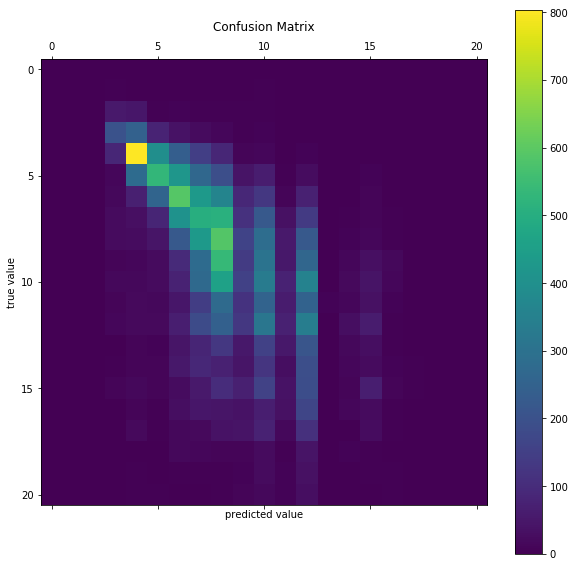

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
labels = np.linspace(20,120, 21)
mat = confusion_matrix(y2, y2_svmodel, labels)

print(mat)

plt.rcParams['figure.figsize'] = [10,10]
fig = plt.figure()          
ax = fig.add_subplot(111) #adding a subplot that is a single frame/facet 111 = (1,1,1) describing rows columns and index, respectively
cax = ax.matshow(mat)          #displays and array as a matrix
plt.title('Confusion Matrix')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)            #have yet to figure how to label the axes correctly
#ax.set_yticklabels([''] + labels)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

## Trying to decompose the one-hot to lower dimensionality

In [126]:
hotarray.shape

(103152, 1100)

In [162]:
from sklearn.decomposition import PCA
# reduce dimensionality or normalized AA counts with PCA
pca = PCA(n_components=400)                    #defining pca method parameters. Need 182 to get to 70% variance
decomposed_1hot = pca.fit_transform(hotarray)
pca.fit_transform(hotarray)
type(pca)

sklearn.decomposition.pca.PCA

In [163]:
print(pca.explained_variance_ratio_.cumsum())

[0.01036405 0.01907493 0.02698551 0.03457725 0.04196977 0.04915013
 0.05615472 0.0630335  0.06967649 0.0762419  0.08254068 0.08877509
 0.09486816 0.10090565 0.1066243  0.11225306 0.11782138 0.12320937
 0.12859526 0.1339583  0.13925637 0.14450875 0.1496895  0.15486421
 0.15998575 0.16508155 0.17013102 0.17513695 0.18013638 0.1851235
 0.19004454 0.19494001 0.19981005 0.20467379 0.20949565 0.2142888
 0.21906156 0.22379711 0.22850117 0.23319793 0.23789029 0.24252274
 0.24713568 0.25173218 0.25631689 0.26088433 0.26541285 0.26991318
 0.27439492 0.27885797 0.28330981 0.28774762 0.29216604 0.29654837
 0.30092558 0.3052849  0.30962796 0.31392648 0.31821176 0.32247196
 0.32669364 0.33089806 0.33507917 0.33923914 0.34337139 0.34749508
 0.35158779 0.3556421  0.35967986 0.36369273 0.36770388 0.37169346
 0.37566529 0.37961908 0.38356785 0.38751351 0.39143388 0.39534337
 0.39923392 0.40311031 0.40695123 0.41076869 0.41457557 0.41837614
 0.42213695 0.42587919 0.42961579 0.43332644 0.43700282 0.440671

In [164]:
decomposed_1hot.shape

(103152, 400)

In [165]:
dX = np.concatenate((evidence_df[feature_subset1], decomposed_1hot), axis = 1)
dX.shape

(103152, 425)

In [166]:
from sklearn.model_selection import train_test_split

#X = evidence_df[feature_subset1]
dy = evidence_df[target_value]

#split the data with 80% in training set
dX1, dX2, dy1, dy2 = train_test_split(dX, dy, random_state=0, train_size=0.80)

dy1 = dy1.values.ravel() #Flatten the vector so that it is formatted correctly
dy2 = dy2.values.ravel()

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [167]:
# set hyperparameters and fit model
forest = RandomForestRegressor(200)
forest.fit(dX1, dy1)

# make predictions based on fitted model
dy2_model = forest.predict(dX2)
#predicted = cross_val_predict(forest1, X1, y1, cv=5, n_jobs=-1)

Evaluating the pca decomposed model

In [168]:
# evaluate performance with RMSE
np.sqrt(mean_squared_error(dy2, dy2_model))

10.296248099893694

In [171]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest, dX2, dy2, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.02)


## Identifying Charge Differences Between Predicted and Experimental

In [214]:
X2.columns

Index(['Charge', 'Length', 'A.Norm', 'R.Norm', 'N.Norm', 'D.Norm', 'C.Norm',
       'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'L.Norm', 'K.Norm',
       'M.Norm', 'F.Norm', 'S.Norm', 'T.Norm', 'W.Norm', 'Y.Norm', 'V.Norm',
       'P.Norm', 'pI'],
      dtype='object')

In [415]:
    plt.scatter(X2['Charge'], X2['pyCharge'], c = X2['Retention.time'], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow'))
    
    plt.colorbar(label='Retention time')
    
    
    plt.plot([X2['Charge'].min(), X2['Charge'].max()], [X2['Charge'].min(), X2['Charge'].max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [389]:
SeqCharges = evidence_df[['Sequence', 'Charge', 'Retention.time']]


NameError: name 'TRUE' is not defined

In [359]:
def predictCharge(inputTable, mypH, seqlabel = 'Sequence', chargelabel = 'Charge'):
    predCharge = list()
    mytable = inputTable[[seqlabel, chargelabel]].copy()
    for i in range(0, mytable.shape[0]):
        ps = parser.parse(mytable[seqlabel][i], show_unmodified_termini=True)
        predCharge.append(electrochem.charge(ps, mypH))
        
    mytable['predCharge'] = predCharge
    return(mytable)
    

In [261]:
import numpy as np
from sklearn.metrics import mean_squared_error

def ChargeErrorpH(seqtable, start, end, steps):
    pHvalues = np.linspace(start, end, steps)
    ErrorValues = list()
    myData = pd.DataFrame()
    
    for pH in pHvalues:
        predChargeTable = predictCharge(seqtable, pH)
        ErrorValues.append(np.sqrt(mean_squared_error(predChargeTable['Charge'], predChargeTable['predCharge'])))
        
    myData['model_pH'] = pHvalues
    myData['model_Error'] = ErrorValues
    
    
    return(myData)
    
    

In [395]:
SeqCharges.columns

Index(['Sequence', 'Charge', 'RetentionTime'], dtype='object')

In [394]:
SeqCharges.rename(columns = {'Retention.time':'RetentionTime'}, inplace=True )

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [362]:
pHplot = ChargeErrorpH(SeqCharges, 0.1, 3, 60)

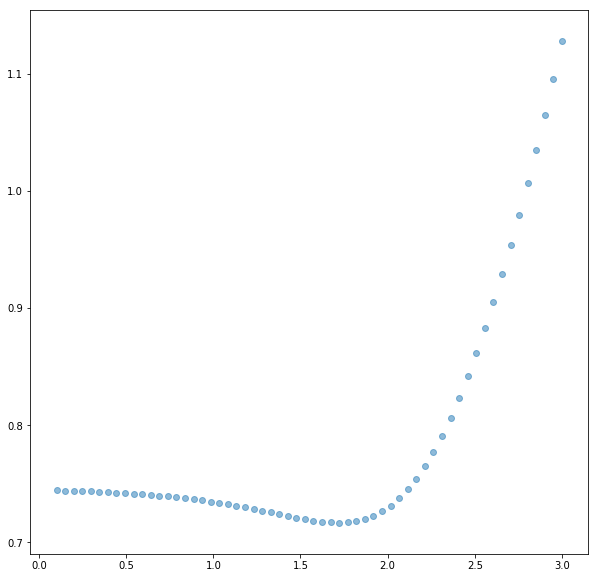

In [365]:
plt.rcParams['figure.figsize'] = [10,10]
plt.scatter(pHplot['model_pH'], pHplot['model_Error'], alpha= 0.5)

In [431]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def ChargeErrorRT(seqtable, steps):
    rtblocks = list(np.linspace(10, 55, steps))
    ErrorValues = list()
    RTEnds = list()
    myData = pd.DataFrame()
    
    for i in range(1, len(rtblocks)):
        block = seqtable.loc[(seqtable.RetentionTime >= rtblocks[i-1]) & (seqtable.RetentionTime < rtblocks[i])]
        block.index = range(0, block.shape[0]) #Copy needs to be reindexed
        block = predictCharge(block, 2.4)
        ErrorValues.append(np.sqrt(mean_squared_error(block['Charge'], block['predCharge'])))
        RTEnds.append(rtblocks[i])
    
    myData['EndofBlock'] = RTEnds
    myData['ChargeError'] = ErrorValues
    
    return(myData)
    
        
        

In [432]:
TestRTError = ChargeErrorRT(SeqCharges, 100)


In [433]:
TestRTError.head()


,EndofBlock,ChargeError
0,10.454545,0.451336
1,10.909091,1.324851
2,11.363636,0.860332
3,11.818182,0.860566
4,12.272727,0.789707


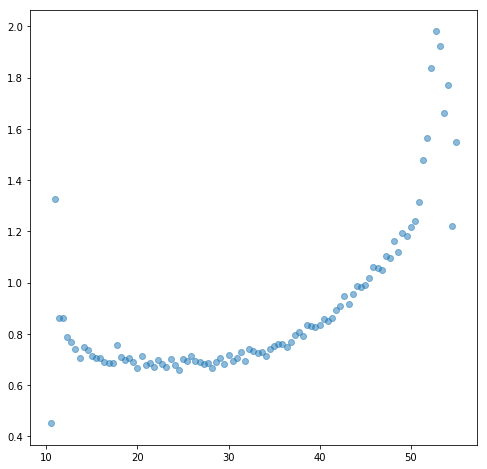

In [434]:
plt.rcParams['figure.figsize'] = [8,8]
plt.scatter(TestRTError['EndofBlock'], TestRTError['ChargeError'], alpha= 0.5)

In [418]:
block.index = range(0, block.shape[0])

In [388]:
SeqCharges.columns


Index(['Sequence', 'Charge', 'Retention.time'], dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def ChargeErrorpH(seqtable, start, end, steps):
    pHvalues = np.linspace(start, end, steps)
    ErrorValues = list()
    myData = pd.DataFrame()
    
    for pH in pHvalues:
        predChargeTable = predictCharge(seqtable, pH)
        ErrorValues.append(np.sqrt(mean_squared_error(predChargeTable['Charge'], predChargeTable['predCharge'])))
        
    myData['model_pH'] = pHvalues
    myData['model_Error'] = ErrorValues
    
    
    return(myData)

In [446]:
#Trying to combine pH and RT  to look at predicted charge error

def ChargeError(seqtable, rtsteps, phstart, phend, phsteps):
    
    RTlist = list()
    pHlist = list()
    #ExpCharge = list()
    ErrorValues = list()
    ErrorFrame = pd.DataFrame()
    rtblocks = list(np.linspace(10, 50, rtsteps))
    pHvalues = np.linspace(phstart, phend, phsteps)
    
    for i in range(1, len(rtblocks)):
        block = seqtable.loc[(seqtable.RetentionTime >= rtblocks[i-1]) & (seqtable.RetentionTime < rtblocks[i])]
        block.index = range(0, block.shape[0]) #Copy needs to be reindexed
        for pH in pHvalues:
            predChargeTable = predictCharge(block, pH)
            ErrorValues.append(np.sqrt(mean_squared_error(predChargeTable['Charge'], predChargeTable['predCharge'])))
            RTlist.append(( rtblocks[i-1] + rtblocks[i])/2)
            pHlist.append(pH)
            
    ErrorFrame['RetentionTime'] = RTlist
    ErrorFrame['pH'] = pHlist
    ErrorFrame['MSE'] = ErrorValues
    
    return(ErrorFrame)

In [447]:
TestErrorFrame = ChargeError(SeqCharges, 100, 0.1, 4, 100)

In [450]:
TestErrorFrame.head()
plt.rcParams['figure.figsize'] = [10,10]

Text(0, 0.5, 'pH')

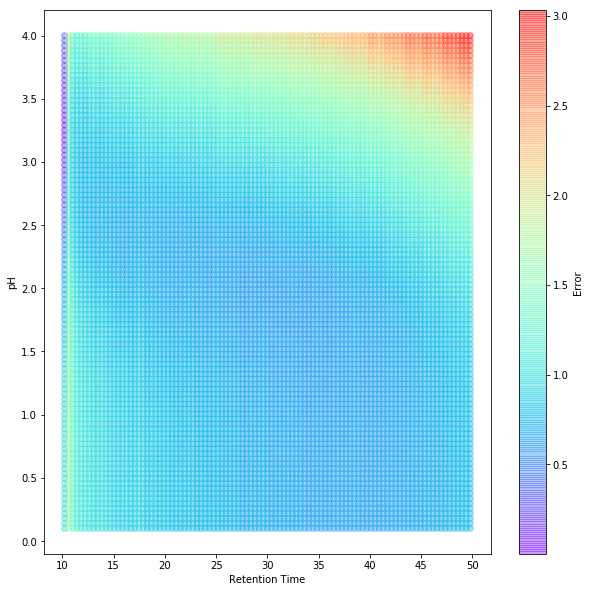

In [452]:
plt.scatter(TestErrorFrame['RetentionTime'], TestErrorFrame['pH'], c = TestErrorFrame['MSE'], alpha= 0.4,
               cmap=plt.cm.get_cmap('rainbow'))
    
    
plt.colorbar(label='Error')
    
    
#plt.plot([TestErrorFrame['RetentionTime'].min(), TestErrorFrame['RetentionTime'].max()], 
         #[TestErrorFrame['pH'].min(), TestErrorFrame['pH'].max()], 'k--', lw=4)
plt.xlabel('Retention Time')
plt.ylabel('pH')

In [ ]:
#Defining the function for adding the pyteomic pieces
from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem


def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)

## Bringing in Max CVs based on averages and with weights

In [16]:
import pandas as pd
import sklearn
import sklearn.ensemble

evidence_df = pd.read_csv("Features_AvgMaxCV_Weights.csv", low_memory=False)
evidence_df.head()

,Sequence,Charge,Intensity,Length,Modifications,Modified.sequence,Oxidation..M..Probabilities,Oxidation..M..Score.Diffs,Acetyl..Protein.N.term.,Oxidation..M.,...,L.Norm,K.Norm,M.Norm,F.Norm,S.Norm,T.Norm,W.Norm,Y.Norm,V.Norm,P.Norm
0,AAAAAAAAAAAAAAAGAGAGAK,2,548850.0,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,...,0.000000,0.045455,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,AAAAAAAAAAAAAAAGAGAGAK,3,7280200.0,22,Unmodified,_AAAAAAAAAAAAAAAGAGAGAK_,NaN,NaN,0,0,...,0.000000,0.045455,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,4,12120000.0,52,Unmodified,_AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVG...,NaN,NaN,0,0,...,0.019231,0.000000,0.0,0.0,0.057692,0.057692,0.0,0.0,0.057692,0.076923
3,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...,5,14383000.0,52,Unmodified,_AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVG...,NaN,NaN,0,0,...,0.019231,0.000000,0.0,0.0,0.057692,0.057692,0.0,0.0,0.057692,0.076923
4,AAAAAAAAAVSR,2,14281000.0,12,Unmodified,_AAAAAAAAAVSR_,NaN,NaN,0,0,...,0.000000,0.000000,0.0,0.0,0.083333,0.000000,0.0,0.0,0.083333,0.000000


In [30]:
#Lets just grab the labels that matter
evidence_df.columns


focuscolumns = ['AvgMaxCV', 'Simple_Max_CV', 'Sequence', 'Charge', 'Length', 'PEP', 'Score', 'A.Norm', 'R.Norm', 'N.Norm', 'D.Norm',
                'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'K.Norm', 'L.Norm', 'M.Norm', 
                'N.Norm', 'P.Norm', 'S.Norm', 'T.Norm', 'V.Norm', 'W.Norm', 'Y.Norm', 'Weighting', 'Total_Observations',
                'ObservationsMaxCV', 'PeptideCharge'
               ]

featureTarget = evidence_df[focuscolumns]

evidence_df = featureTarget

Text(0, 0.5, 'Simple Max')

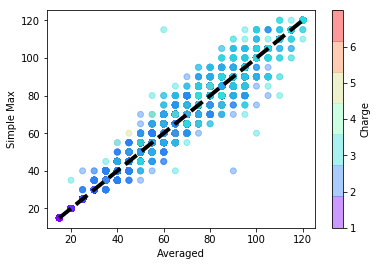

In [18]:
import matplotlib.pyplot as plt

plt.scatter(featureTarget['AvgMaxCV'], featureTarget['Simple_Max_CV'], c = featureTarget['Charge'], alpha= 0.4,
           cmap=plt.cm.get_cmap('rainbow', 7))

plt.colorbar(label='Charge', ticks=range(7))


plt.plot([featureTarget['AvgMaxCV'].min(), featureTarget['AvgMaxCV'].max()], [featureTarget['AvgMaxCV'].min(), 
                                                                              featureTarget['AvgMaxCV'].max()], 'k--', lw=4)
plt.xlabel('Averaged')
plt.ylabel('Simple Max')

### Adding an SVM model

In [36]:
usablefeatures = ['Charge', 'Length', 'A.Norm', 'R.Norm', 'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm',
       'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'K.Norm', 'L.Norm', 'M.Norm',
       'N.Norm', 'P.Norm', 'S.Norm', 'T.Norm', 'V.Norm', 'W.Norm', 'Y.Norm',
       'Weighting']

evidence_df.shape
featureTarget.columns

Index(['AvgMaxCV', 'Simple_Max_CV', 'Sequence', 'Charge', 'Length', 'PEP',
       'Score', 'A.Norm', 'R.Norm', 'N.Norm', 'N.Norm', 'D.Norm', 'C.Norm',
       'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'K.Norm', 'L.Norm',
       'M.Norm', 'N.Norm', 'N.Norm', 'P.Norm', 'S.Norm', 'T.Norm', 'V.Norm',
       'W.Norm', 'Y.Norm', 'Weighting', 'Total_Observations',
       'ObservationsMaxCV', 'PeptideCharge'],
      dtype='object')

In [44]:
#first lets get rid of the really bad scores   evidence_df['Weighting'] < 1


badscores = featureTarget[featureTarget['Weighting'] < 1].index

#badscores.append(list(evidence_df[evidence_df['Weighting'] < 1].index))


#print(len(badscorespep))
#print(len(badscoresweight))
                                             #Delete these bad scoring indices from the array
featureTarget.drop(badscores, inplace=True)
featureTarget.index = range(len(featureTarget))    #Need to reset the indices of your table so they match much like rownames in R


AttributeError: 'DataFrame' object has no attribute 'column'

In [45]:
featureTarget.columns

Index(['AvgMaxCV', 'Simple_Max_CV', 'Sequence', 'Charge', 'Length', 'PEP',
       'Score', 'A.Norm', 'R.Norm', 'N.Norm', 'N.Norm', 'D.Norm', 'C.Norm',
       'Q.Norm', 'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'K.Norm', 'L.Norm',
       'M.Norm', 'N.Norm', 'N.Norm', 'P.Norm', 'S.Norm', 'T.Norm', 'V.Norm',
       'W.Norm', 'Y.Norm', 'Weighting', 'Total_Observations',
       'ObservationsMaxCV', 'PeptideCharge'],
      dtype='object')

In [43]:
#So lets make some weights

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


##FROM DOCUMENTATION
#So this is just exactly what they have in the documentation, so I'll just try to dissect it 

# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

print(type(sample_weight_constant))
print(type(sample_weight_last_ten))
print(sample_weight_constant.shape)
print(sample_weight_last_ten.shape)
sample_weight_last_ten
sample_weight_constant


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(20,)
(20,)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [54]:
from sklearn.model_selection import train_test_split

#Train test split the data
X = featureTarget[usablefeatures]
y = featureTarget['Simple_Max_CV']

#split the data with 80% in training set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.80)

#Hold the weighting factors from training in a numpy array
training_weights_diff = np.array(X1['Weighting'])

#Then also make a constant weghted array just full of ones
training_weights_const = np.array([1] * len(training_weights_diff))

noWeighting = ['Charge', 'Length', 'A.Norm', 'R.Norm', 'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm',
       'E.Norm', 'G.Norm', 'H.Norm', 'I.Norm', 'K.Norm', 'L.Norm', 'M.Norm',
       'N.Norm', 'P.Norm', 'S.Norm', 'T.Norm', 'V.Norm', 'W.Norm', 'Y.Norm']

#Remove the weighting column from X1
X1 = X1[noWeighting]
X2 = X2[noWeighting]




C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [55]:
from sklearn import svm


clf_weights = svm.SVC(gamma=1)

clf_weights.fit(X1, y1, sample_weight = training_weights_diff)


clf_no_weights = svm.SVC(gamma=1)

clf_no_weights.fit(X1, y1, sample_weight = training_weights_const)

y2_model_weighted = clf_weights.predict(X2)

y2_model_no_weight = clf_no_weights.predict(X2)

In [59]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y2, y2_model_weighted))  

12.677320648469047